In [15]:
import numpy as np

# Our image processing tools
import skimage.filters
import skimage.io
import skimage.measure
import skimage.morphology
import skimage.segmentation

# Plotting modules and settings.
import matplotlib.pyplot as plt
import seaborn as sns
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
          '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
          '#bcbd22', '#17becf']
sns.set(style='whitegrid', palette=colors, rc={'axes.labelsize': 16})

# The following is specific Jupyter notebooks
%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}

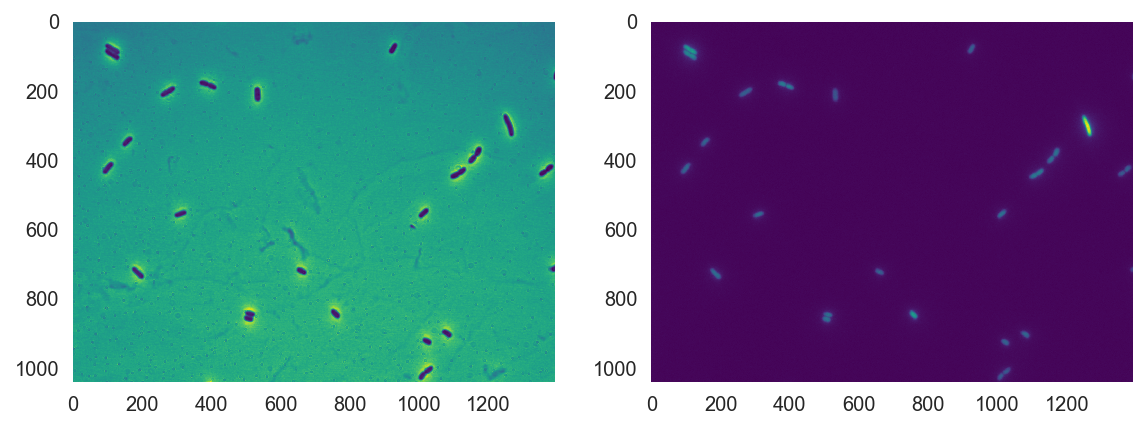

In [16]:
# Load images
im_phase = skimage.io.imread('data/HG105_images/noLac_phase_0004.tif')
im_fl = skimage.io.imread('data/HG105_images/noLac_FITC_0004.tif')

# Display side-by-side
with sns.axes_style('dark'):
    fig, ax = plt.subplots(1, 2, figsize=(9.5, 8))
    ax[0].imshow(im_phase, cmap=plt.cm.viridis)
    ax[1].imshow(im_fl, cmap=plt.cm.viridis)

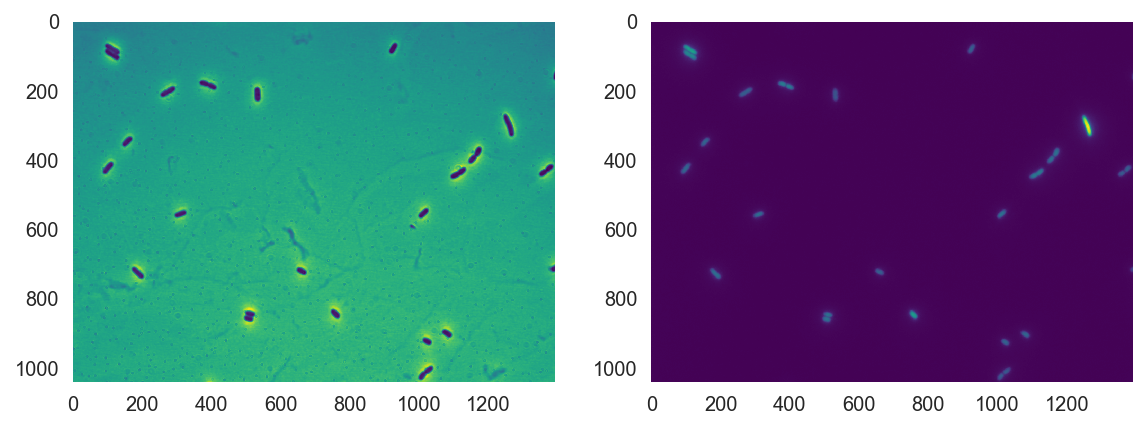

In [17]:
# Structuring element
selem = skimage.morphology.square(3)

# Perform median filter
im_phase_filt = skimage.filters.median(im_phase, selem)
im_fl_filt = skimage.filters.median(im_fl, selem)

# Show the images again
with sns.axes_style('dark'):
    fig, ax = plt.subplots(1, 2, figsize=(9.5, 8))
    ax[0].imshow(im_phase_filt, cmap=plt.cm.viridis)
    ax[1].imshow(im_fl_filt, cmap=plt.cm.viridis)

Must segment in phase when measurements are in fluorescence.  Don't want to segement out your signal.

The background seems to be illuminated unevenly.  Experimentally this can be prevented but in python we will use background substraction.  If you make the image blurry, you can see the background.

/Users/StanHub/anaconda/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:74: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "


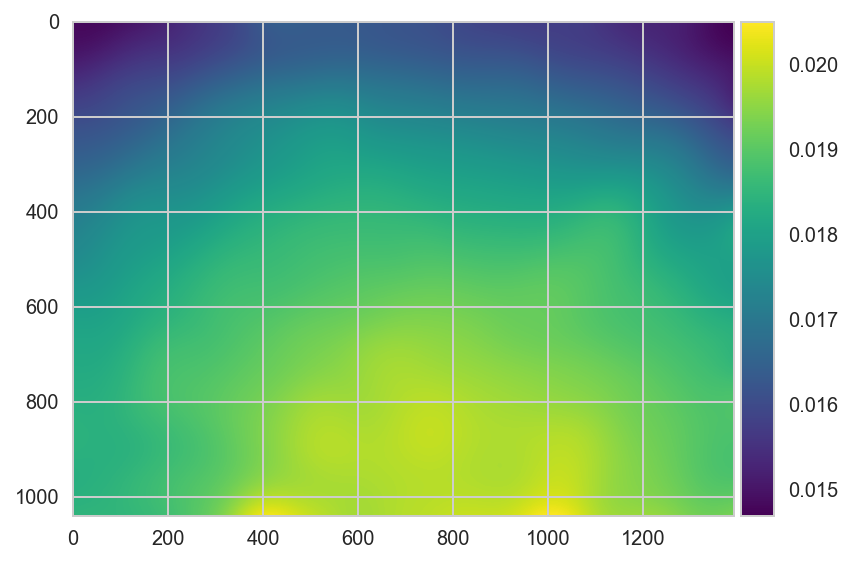

In [18]:
# Apply a gaussian blur
im_phase_gauss = skimage.filters.gaussian(im_phase_filt, 50.0)
skimage.io.imshow(im_phase_gauss)

In [19]:
print(im_phase.dtype)
print(im_phase_gauss.dtype)

uint16
float64


While our input image has a uint16 data type, our Gaussian filtered image is actually a float64. This means in order to have any substantive effect, our original image must also be converted to a float64 before subtraction. We can use the skimage.img_as_float() function to perform this conversion.

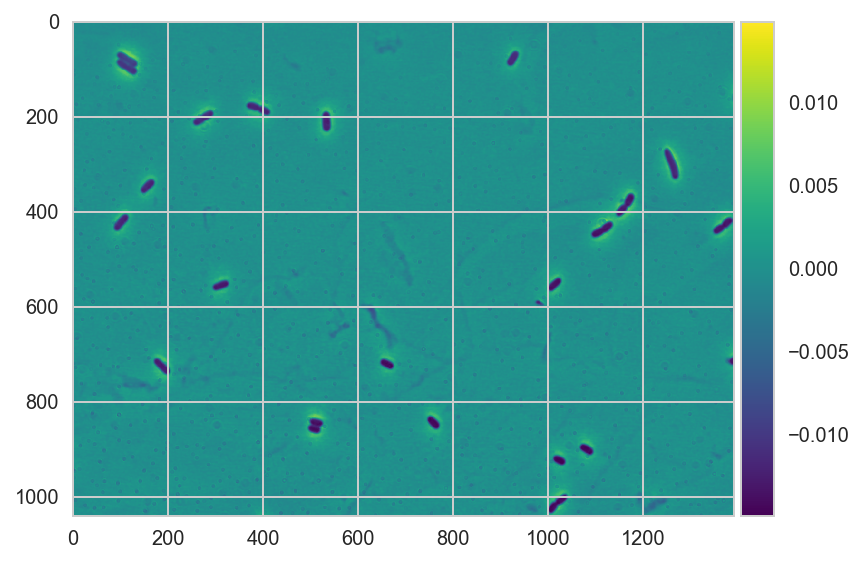

In [20]:
# Convert the median-filtered phase image to a float64
im_phase_float = skimage.img_as_float(im_phase_filt)

# Subtract our gaussian blurred image from the original.
im_phase_sub = im_phase_float - im_phase_gauss

skimage.io.imshow(im_phase_sub, cmap=plt.cm.viridis)

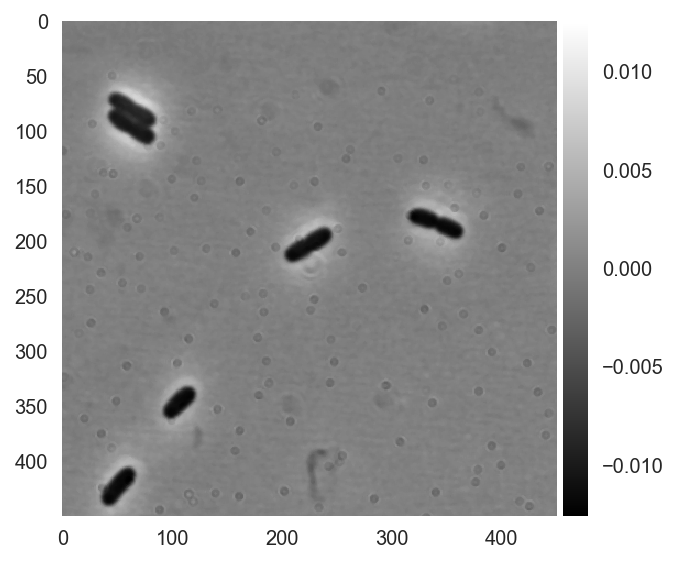

In [21]:
# Indices of subimage
slc = np.s_[0:450, 50:500]

# Look at subimage
with sns.axes_style('dark'):
    skimage.io.imshow(im_phase_sub[slc], cmap=plt.cm.gray)

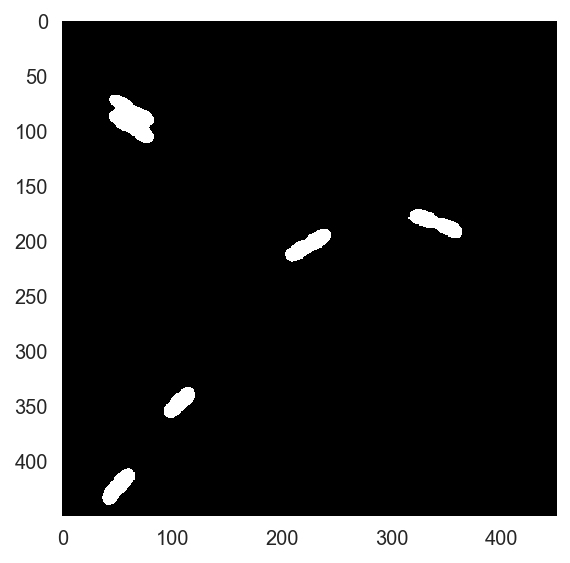

In [22]:
# Compute Otsu threshold value for median filtered image
thresh_otsu = skimage.filters.threshold_otsu(im_phase_sub)

# Construct thresholded image
im_bw = im_phase_sub < thresh_otsu

# Look at image
with sns.axes_style('dark'):
    skimage.io.imshow(im_bw[slc], cmap=plt.cm.gray)

/Users/StanHub/anaconda/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:74: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "


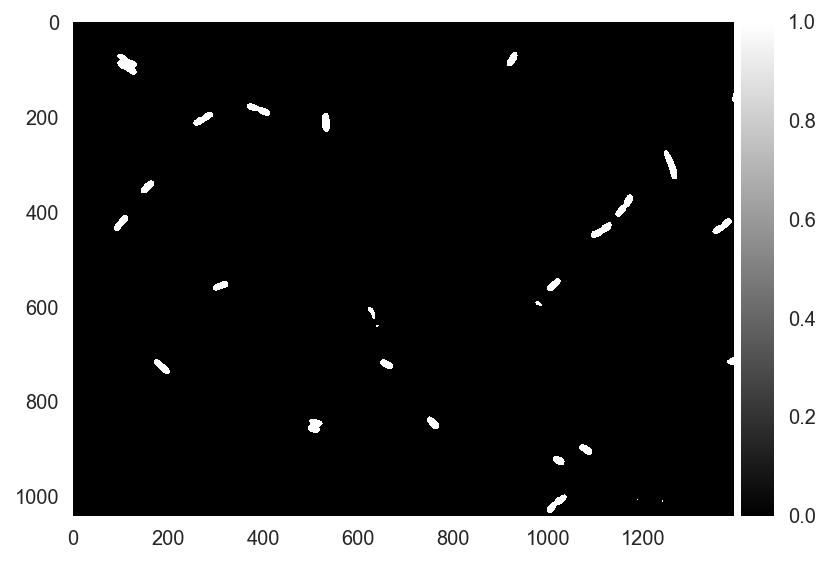

In [23]:
with sns.axes_style('dark'):
    skimage.io.imshow(im_bw, cmap=plt.cm.gray)

# Clear border with 5 pixel buffer
im_bw = skimage.segmentation.clear_border(im_bw, buffer_size=5)

/Users/StanHub/anaconda/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:74: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "


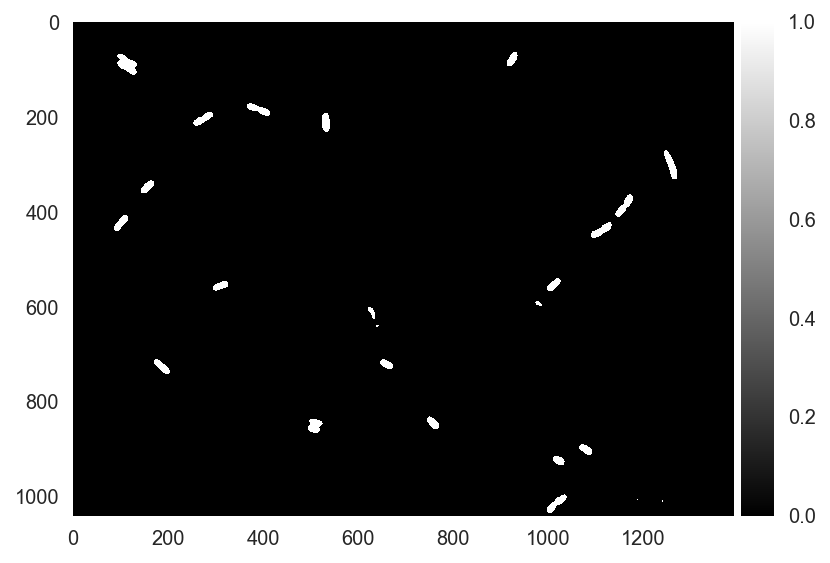

In [24]:
# Notice the borders are gone now.  Not complete bacteria imaged are done.

with sns.axes_style('dark'):
    skimage.io.imshow(im_bw, cmap=plt.cm.gray)

In [25]:
# Label binary image; background kwarg says value in im_bw to be background
im_labeled, n_labels = skimage.measure.label(im_bw, background=0, return_num =True)

/Users/StanHub/anaconda/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:74: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "


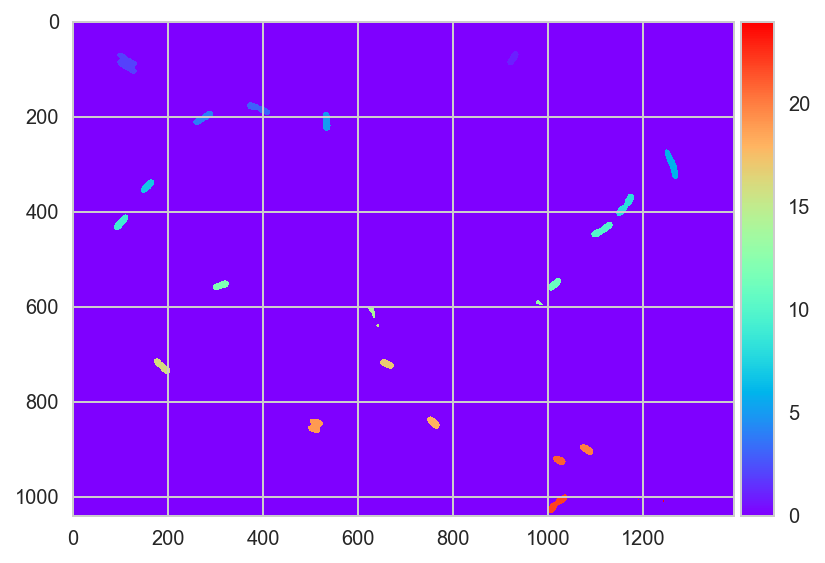

In [29]:
skimage.io.imshow(im_labeled, cmap=plt.cm.rainbow)

In [31]:
# Count em 
n_labels

24

Now you have a key to the locations of every cell in the image that you can use to get to each cell.

In [35]:
# Extract regions properties
im_props = skimage.measure.regionprops(im_labeled, intensity_image=im_fl_filt)

In [36]:
prop = im_props[0]

/Users/StanHub/anaconda/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:74: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "


Number of individual regions =  19


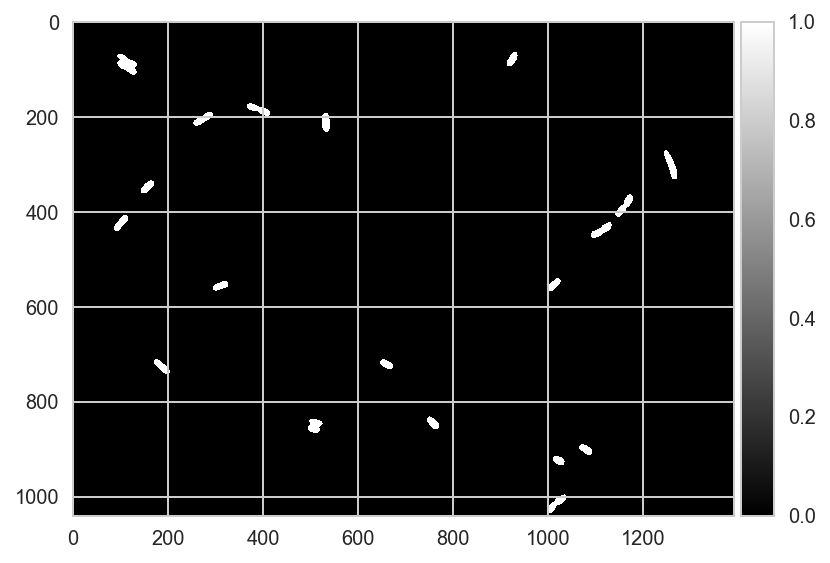

In [45]:
# Make a filtered black and white image
im_bw_filt = im_labeled > 0

# Define cutoff size
cutoff = 200

#Loop through image properties and delete small objects
n_regions = 0
for prop in im_props:
    if prop.area < cutoff:
        im_bw_filt[im_labeled==prop.label]=0
    else:
        n_regions +=1
        
im_props = skimage.measure.regionprops(im_labeled, intensity_image=im_fl_filt)

skimage.io.imshow(im_bw_filt, cmap=plt.cm.gray)

# Show number of regions
print('Number of individual regions = ', n_regions)

In [46]:
int_intensity = [prop.area * prop.mean_intensity for prop in im_props]

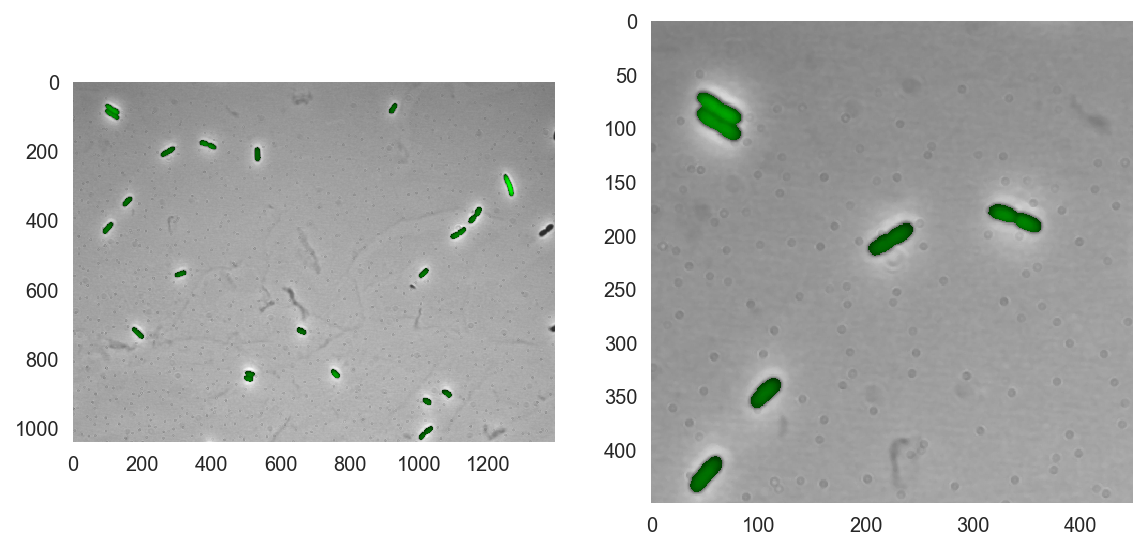

In [48]:
# Build RGB image by stacking grayscale images
im_rgb = np.dstack(3 * [im_phase_filt / im_phase_filt.max()])

# Only show green channel on bacteria
im_rgb[im_bw_filt, 0] = 0
im_rgb[im_bw_filt, 1] = im_fl_filt[im_bw_filt] / im_fl_filt.max()
im_rgb[im_bw_filt, 2] = 0

# Show the result
with sns.axes_style('dark'):
    fig, ax = plt.subplots(1, 2, figsize=(9.5, 8))
    ax[0].imshow(im_rgb)
    ax[1].imshow(im_rgb[slc][:]);